In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance
from astropy.cosmology import Planck15 as cosmo

from regions import Regions, CircleSkyRegion

Now, we look at two catalogs: a big catalog from COSMOS-Web and a small, reduced catalog by someone whose names I forgot.

In [3]:
# this is the name of the BIG catalog file
large_catalog = '/Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits'

In [4]:
# this opens the HDU list of the .fits files and asks for the information within. SCI is what we'll use
hdu_list = fits.open(large_catalog)
hdu_list.info()

# this saves the WCS setting to be used later
wcs = WCS(hdu_list[1].header)

Filename: /Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    802   913253R x 155C   [K, D, D, 3A, D, 4A, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, K, E, E, K, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [5]:
# this gets the data of the big catalog. "cat" stands for catalog!
cat_data = hdu_list[1].data

In [6]:
# closes the data file
hdu_list.close()

In [7]:
# create an empty 2D array to put the ID, RA and DEC of galaxies into
big_cat_ra_dec = np.empty(shape=(np.size(cat_data), 3), dtype='float')

In [8]:
# put the ID, RA and DEC of galaxies in the big catalog into the previously made array
for i in range(np.size(cat_data)):
    ra_dec = np.array(cat_data[i][0:3])
    big_cat_ra_dec[i] = ra_dec

In [9]:
# this is the name of the SMALL catalog
small_catalog = '/Users/ngbinh/Downloads/qg_candidates_bagpipesv1.txt'

# this reads in the small catalog and skips all the long headers
with open(small_catalog) as f:
    lines = (line for line in f if not line.startswith('#'))
    small_cat_data = np.loadtxt(lines, dtype='str', delimiter=',', skiprows=1)

In [10]:
# extract the ID, RA and DEC of galaxies in the small catalog
small_cat_ra_dec = np.asarray(small_cat_data[:,0:3], dtype=float)

In [11]:
### NOW, WE CHECK FOR THE FIRST OVERLAPS 

# we check the IDs of the galaxies in both of the big and small catalogs.
# if two IDs overlap, it means both IDs belong to the same one quenched galaxy, since 
# the small catalog only contains quenched galaxies.
quenched = np.intersect1d(big_cat_ra_dec[:,0], small_cat_ra_dec[:,0], assume_unique = False, return_indices = False)

# now we subtract all the quenched galaxies from the big catalogs,
# leaving behind only the RAs and Decs of their potential neighbors.
potential_neighbors = big_cat_ra_dec
for i in range(np.size(big_cat_ra_dec[:,0])):
    id = big_cat_ra_dec[i][0]
    if id in quenched:
        potential_neighbors = np.delete(potential_neighbors, i, axis=0)

In [12]:
### NOW, WE CHECK FOR THE SECOND OVERLAPS 

# we check the RAs and Decs of the galaxies in both of the big and small catalogs.
# if the coordinates (RA and Dec) overlap, it means they're the coordinates of the same one quenched galaxy,
# which might have one way or another been assigned with different IDs, allowing it to evade our last search.

for i in range(np.size(small_cat_ra_dec[:,0])):
    # first, we pick one of the confirmed quenched galaxies from the small catalog
    conf_quenched = small_cat_ra_dec[:,1:][i]

    # next, we find the coords element in potential_neighbors that overlaps with the coords of the confirmed quenched galaxy
    overlap_index = np.where(potential_neighbors[:,1:] == conf_quenched)

    # next, we locate the overlapped element in potential_neighbors, then delete it
    potential_neighbors = np.delete(potential_neighbors, overlap_index, axis=0)

In [13]:
# just a sanity check. if our code works, then the number of rows in potential_neighbors should be 
# LESS than the difference between that of big_cat_ra_dec and small_cat_ra_dec. we know this because 
# when they were equal, the later results didn't make sense, which prompted us to go back and reevaluate 
# our determination of how big potential_neighbors should be.

print(np.shape(small_cat_ra_dec))
print(np.shape(big_cat_ra_dec))
print(np.shape(potential_neighbors))

(258, 3)
(913253, 3)
(912224, 3)


In [14]:
potential_neighbors_cat = SkyCoord(ra=potential_neighbors[:,1]*u.degree, dec=potential_neighbors[:,2]*u.degree)
quenched_cat = SkyCoord(ra=small_cat_ra_dec[:,1]*u.degree, dec=small_cat_ra_dec[:,2]*u.degree)

In [15]:
print(potential_neighbors[:,1])

[149.79319478 149.75362979 149.75347303 ... 150.5086953  150.50870199
 150.49236554]


In [16]:
# now, we search for all the neighbors of the quenched galaxies, within a given distance

dist = 5 # trying not to hardcode the distance here just in case we need to change it
idx_quenched, idx_potential, sep2d, dist3d = potential_neighbors_cat.search_around_sky(quenched_cat, dist*u.arcsec)
np.all(sep2d < dist*u.arcsec)

True

In [17]:
# using the indices retrieved from the previous cell, we find the RA and Dec of all the confirmed neighbors
conf_neighbor_ra = potential_neighbors[:,1][idx_potential] # in degrees
conf_neighbor_dec = potential_neighbors[:,2][idx_potential] # in degrees

In [18]:
# using the indices retrieved from 2 cells above, we find the RA and Dec of all the quenched galaxies
# that the confirmed neighbors are, well, neighbors to. some elements in these arrays will be repeated
# because one quenched galaxy might have more than one neighbor within the specified angular distance!
conf_quenched_ra = small_cat_ra_dec[:,1][idx_quenched] # in degrees
conf_quenched_dec = small_cat_ra_dec[:,2][idx_quenched] # in degrees

In [19]:
# now, subtract to get delta_RA and delta_Dec.
delta_ra = np.abs(conf_quenched_ra - conf_neighbor_ra) # in degrees
delta_dec = np.abs(conf_quenched_dec - conf_neighbor_dec) # in degrees

/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_3371/2678816876.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


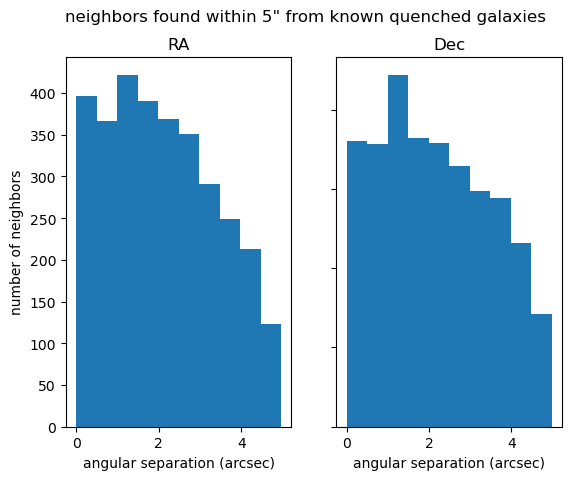

In [20]:
# now make histograms summarizing the angular separations

fig, axs = plt.subplots(1, 2)
fig.suptitle('neighbors found within ' + str(dist) + '" from known quenched galaxies') # using "str" to avoid hardcoding
axs[0].hist(delta_ra*u.degree.to(u.arcsec)) # this converts the array from degrees into arcsecs for clarity
axs[0].set_title('RA')
axs[1].hist(delta_dec*u.degree.to(u.arcsec)) # this converts the array from degrees into arcsecs for clarity
axs[1].set_title('Dec')

for ax in axs.flat:
    ax.set(xlabel='angular separation (arcsec)', ylabel='number of neighbors')
for ax in axs.flat:
    ax.label_outer()

fig.show()

Now, we look at a catalog of recently spectroscopically confirmed quenched galaxies (QGs).
The same analysis as before will be performed on this catalog.

In [22]:
# this reads in the new confirmed QG catalog and skips the header
df = pd.read_csv('/Users/ngbinh/Downloads/spec_qgs.txt', sep="\s+", header = None, names=['Name', 'RA', 'Dec', 'Redshift'], skiprows=1)

# this saves the data frame as a numpy array of RA and Dec for later usage.
# remember: first column is RA, second is Dec, third is redshift.
spec_qg_ra_dec = df.to_numpy()[1:][:,1:3]
spec_qg_ra_dec = np.vstack(spec_qg_ra_dec).astype(float) # converting dtype from object to float

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_3371/1030496139.py:2: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('/Users/ngbinh/Downloads/spec_qgs.txt', sep="\s+", header = None, names=['Name', 'RA', 'Dec', 'Redshift'], skiprows=1)


In [23]:
spec_qg_cat = SkyCoord(ra=spec_qg_ra_dec[:,0]*u.degree, dec=spec_qg_ra_dec[:,1]*u.degree)
all_cat = SkyCoord(ra=big_cat_ra_dec[:,1]*u.degree, dec=big_cat_ra_dec[:,2]*u.degree)

In [24]:
# now, we search for all the neighbors of the quenched galaxies, within a given distance

dist_new = 1 # trying not to hardcode the distance here just in case we need to change it
idx_spec, idx_maybe, d2d, d3d = all_cat.search_around_sky(spec_qg_cat, dist_new*u.arcsec)
np.all(d2d < dist_new*u.arcsec)

True

In [25]:
# these are the matches
print(df.loc[idx_spec, "Name"])

0      ZF-UDS-7329
1     ZF-COS-20115
17        XMM-2599
17        XMM-2599
17        XMM-2599
20         GS-9209
27    3D-UDS-27939
28    ZF-COS-20032
29    ZF-COS-19589
29    ZF-COS-19589
30    ZF-COS-18842
Name: Name, dtype: object


From this result, we know there are 4 spectroscopically confirmed QGs that are in our catalog: ZF-COS-20115, ZF-COS-20032, ZF-COS-19589 and ZF-COS-18842.

In [27]:
# now, we get the indices of those four great matches (let's just call them FGM for now)
FGM_idx = np.array([1, 28, 29, 30])

# then, get their RAs, Decs and redshifts
FGM_catalog_names = df.loc[FGM_idx, "Name"].to_numpy()
FGM_ra = df.loc[FGM_idx, "RA"].to_numpy() # reminder: unit is in degrees
FGM_dec = df.loc[FGM_idx, "Dec"].to_numpy() # reminder: unit is in degrees
FGM_redshift = df.loc[FGM_idx, "Redshift"].to_numpy() * cu.redshift

In [28]:
print(FGM_ra)

[150.06149 150.11256 150.06671 150.08728]


From now on, for the sake of memorability, these important quenched galaxies will be named after the rivers of Vietnam. The reason is because Vietnam (my homeland) is a country with MANY, MANY rivers (a limitless source of names), and because galaxies are referred to as "thiên hà" (heavenly rivers) in Vietnamese.

In [30]:
# new step (May 17, 2024): two more quenched galaxies have been discovered. let's give them their own names.
FGM_ra = np.concatenate((FGM_ra, np.array([150.106932, 150.108873])), axis=0)
FGM_dec = np.concatenate((FGM_dec, np.array([2.377961, 2.330539])), axis=0)
FGM_redshift = np.concatenate((FGM_redshift, np.array([4.570, 3.238])), axis=0)

In [31]:
print(FGM_ra, FGM_dec, FGM_redshift)

[150.06149  150.11256  150.06671  150.08728  150.106932 150.108873] [2.37868   2.3765266 2.3823645 2.3960431 2.377961  2.330539 ] [3.715 2.474 3.715 3.782 4.57  3.238] redshift


In [32]:
# let's print out some reminders about the galaxies and their names
FGM_names = np.array(['Hong', 'Bach-Dang', 'Thu-Bon', 'Gianh', 'Dong-Nai', 'Saigon'])

i = 0
while i < np.size(FGM_catalog_names):
    print(FGM_catalog_names[i] + ' corresponds to the ' + FGM_names[i] + ' River')
    i += 1

print('The remaining, newly discovered QGs are called', FGM_names[i:], ', respectively.')

ZF-COS-20115 corresponds to the Hong River
ZF-COS-20032 corresponds to the Bach-Dang River
ZF-COS-19589 corresponds to the Thu-Bon River
ZF-COS-18842 corresponds to the Gianh River
The remaining, newly discovered QGs are called ['Dong-Nai' 'Saigon'] , respectively.


In [33]:
FGM_cat = SkyCoord(ra=FGM_ra*u.degree, dec=FGM_dec*u.degree)

In [34]:
# now, we search for all the neighbors of the four great matches (FGM), within a given distance

dist_FGM = 5 # trying not to hardcode the distance here just in case we need to change it
idx_FGM, idx_FGM_neighbors, FGM_sep2d, FGM_dist3d = all_cat.search_around_sky(FGM_cat, dist_FGM*u.arcsec)
np.all(FGM_sep2d < dist_FGM*u.arcsec)

True

In [35]:
# using the indices retrieved from the previous cell, we find the RA and Dec of all the confirmed neighbors
FGM_neighbor_ra = big_cat_ra_dec[:,1][idx_FGM_neighbors] # in degrees
FGM_neighbor_dec = big_cat_ra_dec[:,2][idx_FGM_neighbors] # in degrees

In [36]:
# using the indices retrieved from 2 cells above, we find the RA and Dec of all the quenched galaxies
# that the confirmed neighbors are, well, neighbors to. some elements in these arrays will be repeated
# because one quenched galaxy might have more than one neighbor within the specified angular distance!
FGM_quenched_ra = FGM_ra[idx_FGM] # in degrees
FGM_quenched_dec = FGM_dec[idx_FGM] # in degrees

In [37]:
# now, subtract to get delta_RA and delta_Dec.
delta_ra_FGM = np.abs(FGM_quenched_ra - FGM_neighbor_ra) # in degrees
delta_dec_FGM = np.abs(FGM_quenched_dec - FGM_neighbor_dec) # in degrees

/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_3371/458275265.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


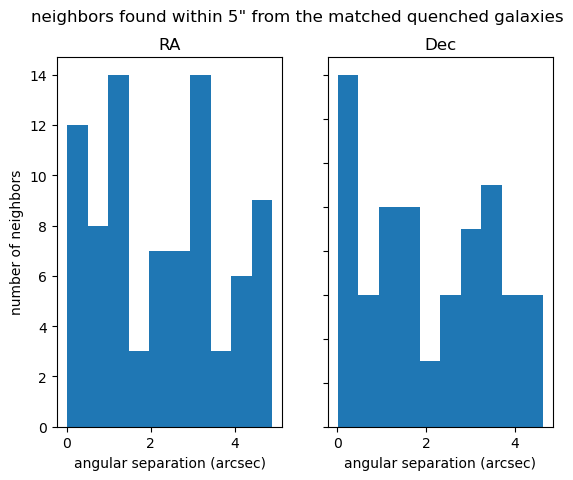

In [38]:
# now make histograms summarizing the angular separations

fig, axs = plt.subplots(1, 2)
fig.suptitle('neighbors found within ' + str(dist_FGM) + '" from the matched quenched galaxies') # using "str" to avoid hardcoding
axs[0].hist(delta_ra_FGM*u.degree.to(u.arcsec)) # this converts the array from degrees into arcsecs for clarity
axs[0].set_title('RA')
axs[1].hist(delta_dec_FGM*u.degree.to(u.arcsec)) # this converts the array from degrees into arcsecs for clarity
axs[1].set_title('Dec')

for ax in axs.flat:
    ax.set(xlabel='angular separation (arcsec)', ylabel='number of neighbors')
for ax in axs.flat:
    ax.label_outer()

fig.show()

In [39]:
# next, we use 35 kpc (from Suess et al, 2023) and the redshifts of the FGM 
# to find a corresponding searching radius for neighbors around each of them.
d_Suess = 35 * u.kpc

In [40]:
# then, get a corresponding distance from each redshift, and then an angular size
FGM_distance = cosmo.kpc_proper_per_arcmin(FGM_redshift)
angular_sizes = (d_Suess / FGM_distance).to(u.arcsec)

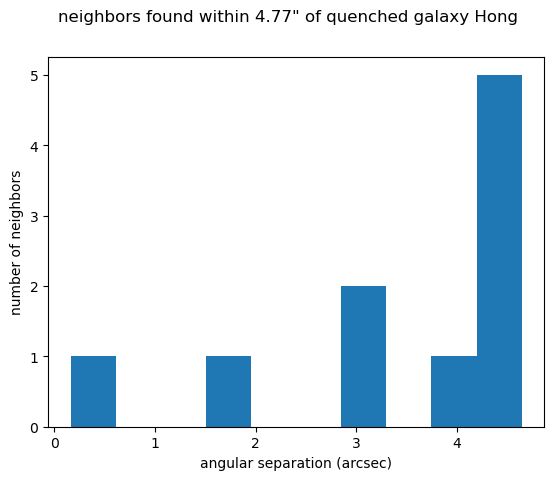

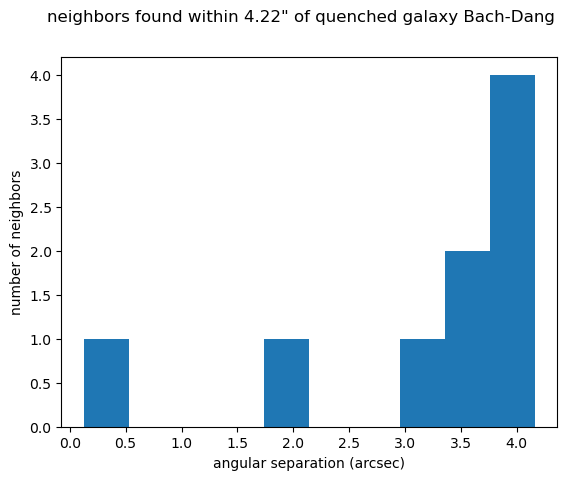

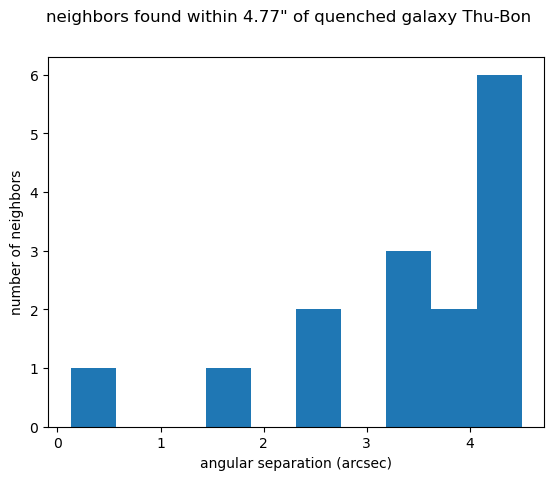

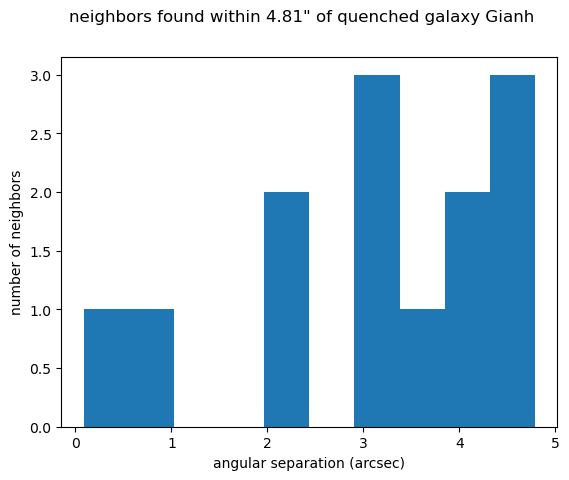

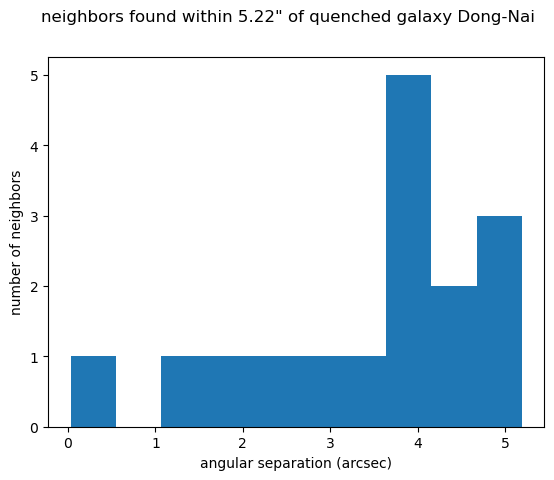

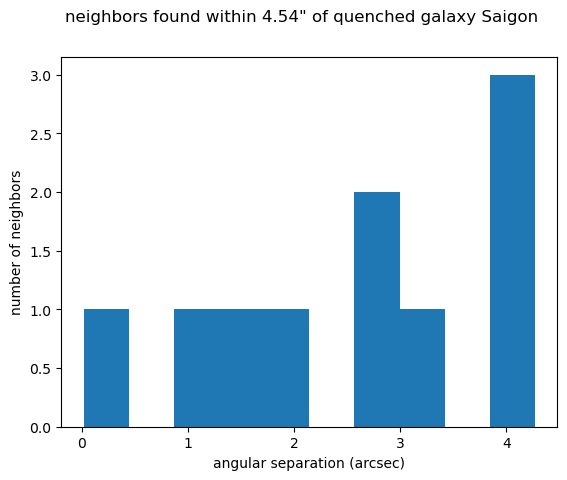

In [41]:
# now, loop through each of the FGM, use the corresponding angular size
# and search for neighbors within that angular size

for i in range(np.size(angular_sizes)):
    # first, call the RA and Dec of the matched QG and its corresponding angular size (aka search radius)
    FGM_proper_ra = FGM_ra[i]
    FGM_proper_dec = FGM_dec[i]
    FGM_ra_dec = FGM_cat[i]
    FGM_name = FGM_names[i]
    search_radius = angular_sizes[i]

    # now, search for neighbors
    d2d = FGM_ra_dec.separation(all_cat)
    catalog_mask = d2d < search_radius
    
    # now, match the neighbors' indices with their RA and Dec
    FGM_near_ra = big_cat_ra_dec[:,1][catalog_mask] # in degrees
    FGM_near_dec = big_cat_ra_dec[:,2][catalog_mask] # in degrees

    # now, subtract to get delta_RA and delta_Dec.
    del_ra_FGM = np.abs(FGM_proper_ra - FGM_near_ra) # in degrees
    del_dec_FGM = np.abs(FGM_proper_dec - FGM_near_dec) # in degrees

    # now, we convert the array from degrees into arcsecs for clarity, then take the vector delta
    del_vector_FGM = np.sqrt((del_ra_FGM*u.degree.to(u.arcsec))**2 + (del_dec_FGM*u.degree.to(u.arcsec))**2)

    # now make histograms summarizing the angular separations
    fig, ax = plt.subplots(1, 1)
    fig.suptitle('neighbors found within ' + str(np.round(search_radius.value, 2)) \
                 + '" of quenched galaxy ' + FGM_name) # using "str" to avoid hardcoding
    ax.hist(del_vector_FGM) # this converts the array from degrees into arcsecs for clarity
    ax.set(xlabel='angular separation (arcsec)', ylabel='number of neighbors')
    
    fig.savefig('river_hist/hist' + FGM_name + '.png')

In [42]:
print(FGM_catalog_names)
print(FGM_names)
print(FGM_ra)
print(FGM_dec)
print(FGM_redshift.value)

['ZF-COS-20115' 'ZF-COS-20032' 'ZF-COS-19589' 'ZF-COS-18842']
['Hong' 'Bach-Dang' 'Thu-Bon' 'Gianh' 'Dong-Nai' 'Saigon']
[150.06149  150.11256  150.06671  150.08728  150.106932 150.108873]
[2.37868   2.3765266 2.3823645 2.3960431 2.377961  2.330539 ]
[3.715 2.474 3.715 3.782 4.57  3.238]
